In [9]:
# Install & set up YOLOv7 (uncomment to run)
!git clone https://github.com/WongKinYiu/yolov7.git
%cd yolov7
!pip3 install -r requirements.txt

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.23 MiB | 8.48 MiB/s, done.
Resolving deltas: 100% (519/519), done.
/Users/leoyaoair23/MacAirLeoYao/Spring 2025/DL/project/yolov7/yolov7


/Users/leoyaoair23/Library/Python/3.9/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
# Create a dataset config YAML for YOLOv7
import yaml
data_cfg = {
    'train': '../dataset/Training',
    'val':   '../dataset/Testing',
    'nc':    4,
    'names': ['glioma', 'meningioma', 'notumor', 'pituitary']
}
with open('brain_tumor.yaml', 'w') as f:
    yaml.dump(data_cfg, f, default_flow_style=False)

In [3]:
# Imports
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Add yolov7 repo to path
import sys
sys.path.append('yolov7')

In [7]:
# Train YOLOv7
# (This will write training logs and curves into runs/train/exp/)
!python3 train.py \
    --img 200 200 \
    --batch 16 \
    --epochs 20 \
    --data brain_tumor.yaml \
    --cfg cfg/training/yolov7.yaml \
    --weights 'yolov7.pt' \
    --device 0

/Users/leoyaoair23/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Traceback (most recent call last):
  File "/Users/leoyaoair23/MacAirLeoYao/Spring 2025/DL/project/yolov7/train.py", line 595, in <module>
    device = select_device(opt.device, batch_size=opt.batch_size)
  File "/Users/leoyaoair23/MacAirLeoYao/Spring 2025/DL/project/yolov7/utils/torch_utils.py", line 71, in select_device
    assert torch.cuda.is_available(), f'CUDA unavailable, invalid device {device} requested'  # check availability
AssertionError: CUDA unavailable, invalid device 0 requested


FileNotFoundError: [Errno 2] No such file or directory: 'runs/train/exp/results.png'

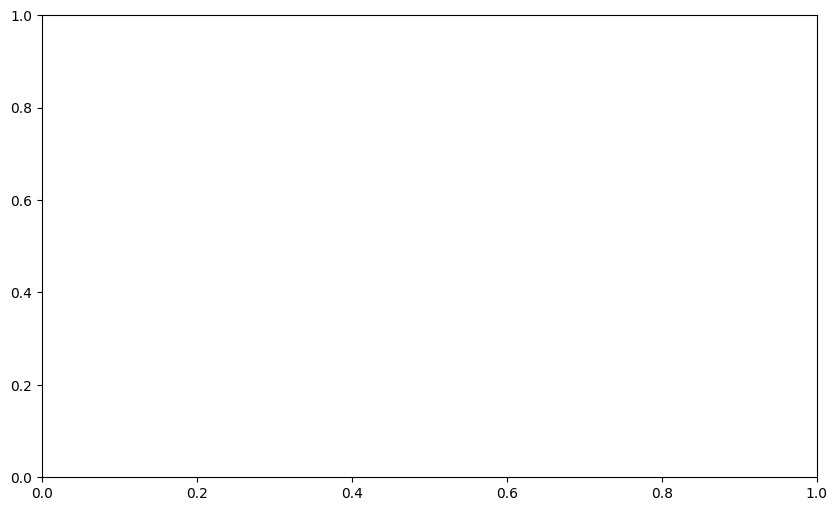

In [8]:
# After training, display the loss & metrics curves that YOLOv7 auto‑generates
from PIL import Image
fig, ax = plt.subplots(figsize=(10, 6))
results_img = Image.open('runs/train/exp/results.png')
ax.imshow(results_img)
ax.axis('off')
plt.title('YOLOv7 Train/Val Loss & mAP Curves')
plt.show()

In [ ]:
# Run inference on test set
!python detect.py \
    --weights runs/train/exp/weights/best.pt \
    --img 200 \
    --conf 0.25 \
    --source ../dataset/Testing \
    --name yolov7_test \
    --project runs/detect

In [ ]:
# Display a few sample detections
import glob

out_dir = 'runs/detect/yolov7_test'
images = glob.glob(os.path.join(out_dir, '*.jpg'))[:3]

fig, axes = plt.subplots(1, len(images), figsize=(len(images)*4, 4))
for ax, img_path in zip(axes, images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
plt.suptitle('Sample YOLOv7 Detections on Test Set')
plt.show()

In [ ]:
# Compute classification metrics (confusion matrix / report)
# We saved text predictions as ../runs/detect/yolov7_test/labels/*.txt
# where each file lists: class_id x_center y_center width height conf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# load ground truths
gt_files = sorted(glob.glob('../dataset/Testing/*/*.jpg'))
gt_labels = [os.path.basename(os.path.dirname(p)) for p in gt_files]

# load preds
pred_files = sorted(glob.glob(os.path.join(out_dir, 'labels', '*.txt')))
pred_labels = []
for txt in pred_files:
    with open(txt) as f:
        line = f.readline().strip().split()
        if line:
            pred_labels.append(int(line[0]))
        else:
            pred_labels.append(-1)

label_map = {name: idx for idx, name in enumerate(data_cfg['names'])}
y_true = [label_map[lbl] for lbl in gt_labels]
y_pred = pred_labels[:len(y_true)]  # align lengths

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(data_cfg['nc'])))
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=data_cfg['names'],
            yticklabels=data_cfg['names'],
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — YOLOv7')
plt.show()

print(classification_report(y_true, y_pred, target_names=data_cfg['names']))